In [1]:
#!pip install sklearn
#!pip install transformers
#!pip install -U ray
#!pip install -U ray[tune]
#!pip install datasets
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import Trainer, TrainingArguments

from ray import tune
from ray.tune import CLIReporter
from ray.tune.suggest.bayesopt import BayesOptSearch

from datasets import load_metric

from cf_matrix import make_confusion_matrix

from IPython.display import clear_output
import logging
logging.basicConfig(level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

## Load and Split Data

In [3]:
# remove emoji from data
def no_emoji(X):
    for i in range(len(X)):
        s = ''
        count = 0
        for j in range(len(X[i])):
            if X[i][j] == "[":
                count += 1
            elif count == 0:
                s += X[i][j]
            if X[i][j] == "]" and count > 0:
                count -= 1
        X[i] = s
        
    return X


# split data to train, validation, test
def split(df, need_emoji = True, random_state = 0):
    X = list(df['review'])
    y = list(df['label'])
    
    # 60% train, 20% development, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = random_state)
    if not need_emoji:
        X_train = no_emoji(X_train)
        X_val = no_emoji(X_val)
        X_test = no_emoji(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

### weibo

In [4]:
# load weibo data
df_weibo = pd.read_csv('data/processed_weibo_data.csv')
df_weibo = df_weibo.dropna().drop("Unnamed: 0", axis = 1)

In [5]:
# split weibo data to train, validation, test
# data with emoji
X_train_wb_1, X_val_wb_1, X_test_wb_1, y_train_wb_1, y_val_wb_1, y_test_wb_1 = split(df_weibo)
# same data with emoji removed
X_train_wb_0, X_val_wb_0, X_test_wb_0, y_train_wb_0, y_val_wb_0, y_test_wb_0 = split(df_weibo, need_emoji = False)

In [6]:
[X_train_wb_1[0:5], X_train_wb_0[0:5]]

[['猛然发现，「财经郎眼」之前的广告是修正牌消糜栓。[衰]',
  '看爪就知道是美女！[亲亲][爱你]',
  '你现在是在去怀柔的路上吗？[哈哈][哈哈] ',
  '时间过得太快，老感觉不够用！[泪]',
  '吃饱喝足谁也不服[哈哈][哈哈][哈哈]'],
 ['猛然发现，「财经郎眼」之前的广告是修正牌消糜栓。',
  '看爪就知道是美女！',
  '你现在是在去怀柔的路上吗？ ',
  '时间过得太快，老感觉不够用！',
  '吃饱喝足谁也不服']]

### dianping

In [7]:
# load dianping data
df_dianping = pd.read_csv('data/processed_dianping_data.csv')
df_dianping = df_dianping.dropna().drop("Unnamed: 0", axis = 1)

In [8]:
# split dianping data to train, validation, test
# dianping data does not have emoji
X_train_dp_0, X_val_dp_0, X_test_dp_0, y_train_dp_0, y_val_dp_0, y_test_dp_0 = split(df_dianping)

In [9]:
X_train_dp_0[0:5]

['中午在旺角逛街，12点多就去了附近的潮楼。那里应该算是早茶的地方的，但是中午人依然很多。还好到的早，不怎么需要等位的。领位的服务生，忙是忙，一时忽略了我们，还打招呼，不好意思。\n绫鱼丸，新鲜鱼肉做的，能吃的出有鱼刺的成分，但是绝对不会卡到的那种，很鲜；\n皮蛋瘦肉粥，好浓的，以至于我和V都说，要么回家以后也把粥煮成这样，但是味道肯定调不好的；\n虾饺，里面真的有3个虾仁，很Q的，要不是吃不下，肯定还会再点的；\n凤爪，比较酥烂，食材本身研制的比较入味，所以很好吃，V说比较适合她妈吃；\n肠粉，里面的料很好，也有虾仁的成分面还有新鲜蔬菜，结合的好香；\nXO酱萝卜糕，因为便宜就点来吃吃，绝对超过了萝卜的口感，超级好吃；\n牛肉丸，做的比较嫩，但是确很Q，跟芹菜结合的，有种特殊的香味。\n最后结帐$123，出乎意料，本来还以为要超200了。这顿真的吃的很舒服。\n',
 '鸟照烧 大家都懂了对伐 20块钱的中饭 还是蛮灵的\n就是感觉很 穷人的感觉，几片腌萝卜 还有鸟照烧 。\n米饭还是蛮好吃的\xa0\xa0MISO有点咸。\n店很古老了....\n',
 '也是从网上看到这个地方的推荐，找了半天都没有找到。瓷器口进去大概是个T型号的路，从最下面进去，往T的丁字口往右走就是江边。快到丁字口的路上，在右边有个非常窄的巷子，不注意就错过。进去才发现别有洞天，里面位置挺宽敞的，里面有个小牌子说是CCTV2推荐的。我们专程点了毛血旺，网上人说这个很地道。这边的毛血旺的确是最老方式的毛血旺，不过味道不太好，感觉重庆城里随便一个摊位上的都比这好吃。还好，点了一个折耳根还下饭，要不然真不知道吃什么。建议，没有什么必要就不要找这个地方吧。\n',
 '一直很怀念那儿的鸡，不知道是怎么做的，但是真的很嫩，每次去人基本上都客满的，还有各种炒菜，只是店小了点，值得一试\n',
 '南非世界杯，2点钟德国的半决赛是在这里看的。\n我觉得麦当劳比肯德基好，最近几年扩张后劲十足，反观肯德基似乎孱弱并且诟病不断，推出不少纯噱头难吃的要死的骗钱食品。\n加之麦咖啡进驻，麦当劳让越来越多人喜欢。\n']

## Load Models

In [10]:
tokenizer = AutoTokenizer.from_pretrained('uer/chinese_roberta_L-12_H-768')

In [11]:
# model with weibo emoji
roberta_weibo_emoji = AutoModelForSequenceClassification.from_pretrained('trained_model/roberta_weibo_emoji')
# classifier
weibo_emoji_classifier = pipeline('sentiment-analysis', model = roberta_weibo_emoji, tokenizer = tokenizer, device = 0)

In [12]:
# model without weibo emoji
roberta_weibo_no_emoji = AutoModelForSequenceClassification.from_pretrained('trained_model/roberta_weibo_no_emoji')
# classifier
weibo_no_emoji_classifier = pipeline('sentiment-analysis', model = roberta_weibo_no_emoji, tokenizer = tokenizer, device = 0)

In [13]:
# uer dianping model
uer_roberta_dianping = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')
# classifier
uer_dianping_classifier = pipeline('sentiment-analysis', model = uer_roberta_dianping, tokenizer = tokenizer, device = 0)

## Assess Performance

In [14]:
# assess performance of model, and print a confusion matrix
def performance(X_test, y_test, classifier, threshold = 0.5):
    #convert = {'positive (stars 4 and 5)': 1, 'negative (stars 1, 2 and 3)': 0}
    convert = {'LABEL_1': 1, 'LABEL_0': 0}
    y_pred = []
    
    for review in X_test:
        prediction = classifier(review)[0]
        label = convert[prediction['label']]
        if label == 1 and prediction['score'] < threshold:
            label = 0
        y_pred.append(label)
        clear_output(wait = True)
        print("{}/{}".format(len(y_pred), len(y_test)))

    cf_matrix = confusion_matrix(y_test, y_pred)
    labels = ['TN', 'FP', 'FN', 'TP']
    categories = ['Negative', 'Positive']
    
    make_confusion_matrix(cf_matrix, group_names = labels, categories = categories, cmap = 'binary')

### weibo emoji model

19093/19093


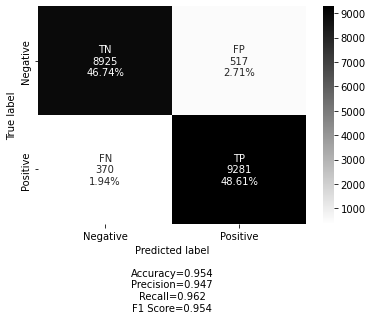

In [15]:
# emoji model performance on weibo data with emoji
performance(X_test_wb_1, y_test_wb_1, weibo_emoji_classifier)

19093/19093


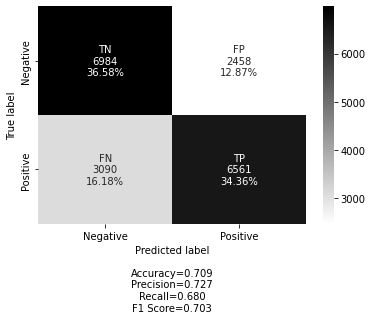

In [16]:
# emoji model performance on weibo data with emoji removed
performance(X_test_wb_0, y_test_wb_0, weibo_emoji_classifier)

19093/19093


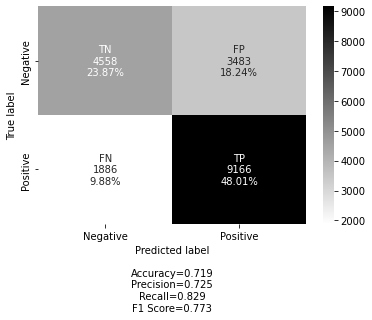

In [17]:
# emoji model performance on dianping data
performance(X_test_dp_0, y_test_dp_0, weibo_emoji_classifier)

### weibo no emoji model

19093/19093


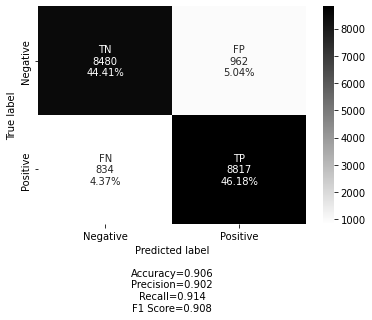

In [18]:
# non emoji model performance on weibo data with emoji
performance(X_test_wb_1, y_test_wb_1, weibo_no_emoji_classifier)

19093/19093


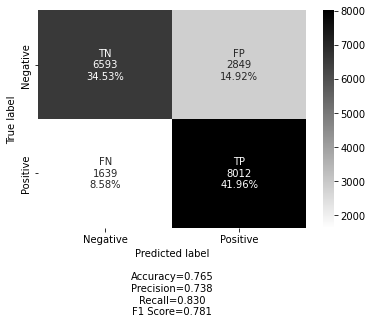

In [19]:
# non emoji model performance on weibo data with emoji removed
performance(X_test_wb_0, y_test_wb_0, weibo_no_emoji_classifier)

19093/19093


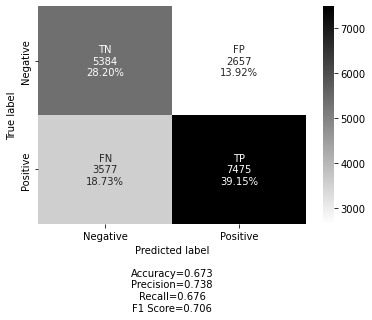

In [20]:
# non emoji model performance on dianping data
performance(X_test_dp_0, y_test_dp_0, weibo_no_emoji_classifier)

### dianping model

In [21]:
# assess performance of model, and print a confusion matrix
def performance(X_test, y_test, classifier, threshold = 0.5):
    convert = {'positive (stars 4 and 5)': 1, 'negative (stars 1, 2 and 3)': 0}
    #convert = {'LABEL_1': 1, 'LABEL_0': 0}
    y_pred = []
    
    for review in X_test:
        prediction = classifier(review)[0]
        label = convert[prediction['label']]
        if label == 1 and prediction['score'] < threshold:
            label = 0
        y_pred.append(label)
        clear_output(wait = True)
        print("{}/{}".format(len(y_pred), len(y_test)))

    cf_matrix = confusion_matrix(y_test, y_pred)
    labels = ['TN', 'FP', 'FN', 'TP']
    categories = ['Negative', 'Positive']
    
    make_confusion_matrix(cf_matrix, group_names = labels, categories = categories, cmap = 'binary')

19093/19093


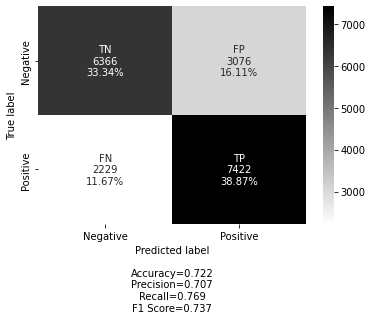

In [22]:
# dianping model performance on weibo data with emoji
performance(X_test_wb_1, y_test_wb_1, uer_dianping_classifier)

19093/19093


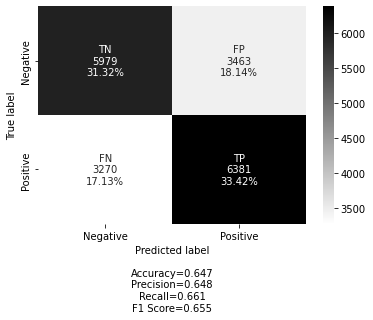

In [23]:
# dianping model performance on weibo data with emoji removed
performance(X_test_wb_0, y_test_wb_0, uer_dianping_classifier)

19093/19093


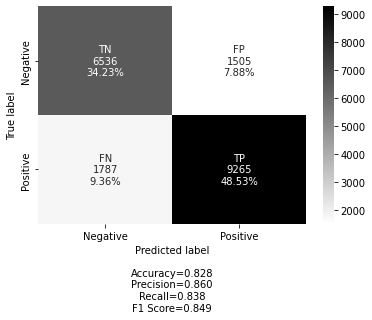

In [24]:
# dianping model performance on dianping data
performance(X_test_dp_0, y_test_dp_0, uer_dianping_classifier)

## Investigate Misclassified Data

In [25]:
def metrics_idx(data, target, classifier):
    threshold = 0.5
    convert = {'LABEL_1': 1, 'LABEL_0': 0}
    y_pred = []

    for review in data:
        prediction = classifier(review)[0]
        label = convert[prediction['label']]
        if label == 1 and prediction['score'] < threshold:
            label = 0
        y_pred.append(label)
    
    tp = (np.array(y_pred) + np.array(target)) == 2
    tn = (np.array(y_pred) + np.array(target)) == 0
    fp = (np.array(y_pred) + 2 * np.array(target)) == 1
    fn = (np.array(y_pred) + 2 * np.array(target)) == 2

    tp_idx = np.where(tp == True)[0]
    tn_idx = np.where(tn == True)[0]
    fp_idx = np.where(fp == True)[0]
    fn_idx = np.where(fn == True)[0]
    
    return tp_idx, tn_idx, fp_idx, fn_idx

In [26]:
# weibo review with emoji on weibo emoji model
y_test_wb_1_emoji_metrics = metrics_idx(X_test_wb_1, y_test_wb_1, weibo_emoji_classifier)

In [27]:
# weibo review without emoji on weibo emoji model
y_test_wb_0_emoji_metrics = metrics_idx(X_test_wb_0, y_test_wb_0, weibo_emoji_classifier)

In [28]:
wb_tp_emoji_diff = np.setdiff1d(y_test_wb_1_emoji_metrics[0], y_test_wb_0_emoji_metrics[0])
np.array(X_test_wb_1)[wb_tp_emoji_diff][0:20]

array(['[鼓掌]', '准备迎接新的一天，睡觉了[哈哈]', 'morning[可爱]',
       '[哈哈][哈哈][哈哈][哈哈][哈哈][哈哈][嘻嘻] ', '出现了[爱你] ',
       '好消息[鼓掌]泰国民主党反政府示威组领导人素贴于昨晚正式宣布无条件解散全国的所有示威活动！想要去泰国曼谷旅游的亲们现在可以放心啦！???????? ????? ?????????? ???????????????? ??????????????? 【via.@韩大黑】',
       '[笑哈哈]', '疲眠不觉晓，处处闻狗腿；夜来电话声，偷听知多少？只是很抱歉，都是重口味[哈哈][哈哈][哈哈]与天斗其乐无穷！',
       '这样哪里是生病了，就是爱干净一些[嘻嘻]',
       '早晨起来看微博，确实很容易让人产生一种皇帝批阅奏章，君临天下的幻觉。国家大事潮水般涌来，需要迅速作出各种判断，提出各种建议，各种转发，各种忧国忧民，各种踌躇满志，万物皆备于我。每个人心中都藏着一个披星戴月上朝堂的皇帝，微博把人的这种情结激活了！ 各位皇帝，早！[嘻嘻]',
       '[good][鼓掌][鼓掌] ', '#带着微博去旅行#这是薄荷岛 刚刚看到的眼睛猴 怎么重觉得像指环王里的某个角色[抱抱]',
       '你有心爱的人了~我不能再陪在你身边了。但请记得~我温暖不了你的身，但却能温暖你的心~[亲亲][挖鼻屎][亲亲] ',
       '去掉了V和其他认证信息，也去掉了学校和职业信息，感觉自由了[嘻嘻]，是不是可以开始干坏事了？',
       '吃完请把餐具放到相应的餐口，如果不放，别忘了走时说句日语[嘻嘻] 我在:http:',
       '[哈哈]让人欢喜让人恨的豆汁啊！好吧.......不多说啦！', '想这么做但是boss不能让你这么做呀[嘻嘻] ',
       '[哈哈]', '[good]', '[哈哈][哈哈][哈哈] '], dtype='<U227')

In [29]:
wb_tn_emoji_diff = np.setdiff1d(y_test_wb_1_emoji_metrics[1], y_test_wb_0_emoji_metrics[1])
np.array(X_test_wb_1)[wb_tn_emoji_diff][0:20]

array(['周六快乐！！[晕]', '诶少爷都去过啦[泪] ',
       '@性感的钻石老爷爷 请我和@占昕 在内蒙古大厦吃饭，先上三楼准备吃蒙餐，一出电梯就好香的肉味，然后说不提供散座[汗][汗]。只好下二楼吃加了15%服务费的豪华小肥羊。汗，这菜单[衰][衰]',
       '#高级定制#  vca定制系列...15mm单花黑玛瑙项链又出现货啦...[哈哈][哈哈][哈哈]全是18k黄金的哦...数量有限 喜欢的赶紧哦...[酷][抓狂][抓狂]提醒大家哦！我们是以付款的先后来发货哦...[话筒][话筒][话筒][做鬼脸]',
       '哈哈，希望下次有机会补上~~[花心][哈哈][泪]',
       '考试完毕，回广州咯，木有车回增城[泪] 我在#江门汽车总站# http:', '大郅牛逼！[泪][泪]',
       '烘焙展不好玩，还是有的的吃才好！下午茶时间我们在夏朵花园补午饭餐，5个人点了披萨、海鲜饭、龙虾面、几样前菜，和8份甜点！！！[抓狂][抓狂][抓狂]',
       '#果冻的幸福生活# 今天和朋友把事情说开真好。[鼓掌]我不聪明，咱有话直说，不然我爱胡思乱想的。[抓狂]你依然是我的好朋友！我认可的哦！[偷笑]好朋友回来，真的很开心！[嘻嘻]',
       '傍晚的太阳很漂亮，但我要回公司继续做「表姐」。[晕]',
       '2013年1月4日 我就是这个日子起飞回国 [飞机]来和关注我的朋友过年[抓狂][爱心传递][haha]',
       '网上看到的一首诗《但你没有》感动cry。。。[泪] （肥啾榭一）', '小明哥[泪]',
       '[悲伤] 儿子和养女，还记得你们是从哪里来的吗？[档案]', '海口是一线了@[泪] ',
       '这个生日礼物我太喜欢了@小牛儿1030 谢谢！[泪]同时也感谢所有关心我！鼓励我！帮助我！支持我的各位亲朋好友…[馋嘴][泪][爱你]小闪闪会继续用心去诠释每一部作品，小闪闪会坚持不懈的努力…就像这幅肖像画一样，一笔一划去勾勒属于我的每一个角色[围观]',
       '今天又?叉?瘾。[泪][泪]肥仔昌?腊店，#01-120 ABC Food Centre.半肥?的不?天吃到high. [馋嘴]',
       '姐飘过~~~[衰]', '感谢

In [30]:
wb_tp_emoji_diff_rev = np.setdiff1d(y_test_wb_0_emoji_metrics[0], y_test_wb_1_emoji_metrics[0])
np.array(X_test_wb_1)[wb_tp_emoji_diff_rev][0:20]

array(['刚到还没进家门呢[?][?][?][困][困][困] ', '我热4-1干掉凯子！[怒] ',
       '炫酷的大迪小迪来一发[抓狂]这个绝壁解不了啊[嘻嘻]/@老真真真真真五:我会疯掉！！！ ',
       '[抓狂][抓狂][抓狂][抓狂]我请吃饭！ ', '回复@鹏的莹:[晕][晕] ',
       '这是一个热死没人管的季节[汗][汗][汗][泪] 爬丹霞山，从夹缝中终于爬上山，经过了嘉遁亭，来到了99天梯下山，我完全傻了。吓傻[黑线][奥特曼] 热傻? @秀媛大牌 每次见你都这么瘦[爱你][爱你]  我在这里:http:',
       '[鼓掌][鼓掌][心][鲜花]老磨坊官门口店，好感动的一幕，[泪]幸福满溢的女人。。。浪漫什么时候都不晚，爱她就是要告诉她！[鼓掌][爱心传递]',
       '【蓝双】据说王导一年前就准备来钻墙啦~~真是好事多磨现在才看到您矫捷的身手~~拿着超级大南瓜，王导选择主动出击，不料墙洞坚实有力，等再晃过神来，只听王导一句：“我的瓜呢？”[晕][哈哈]最神奇的是谢映玲，眼看下一秒就要落水，硬是hold到最后誓死不从！@王为念微博 @滴玲玲玲 #正大综艺微直播#',
       '[爱你]亲有机会一定试试榴莲乳酪  上回没给亲排上 真心抱歉[泪] ', '聚会很欢乐但是我喝多了[泪] ',
       '老妹和奶牛?[爱你]淘淘是个胆小鬼，不出来?[泪]',
       '从几百万瞬间到零的不寻常变动，虽然并不能影响《璀璨人生》的全国收视第一！[hold住]但希望这样人工操控、背离观众的收视污染远离我们的电视圈！[怒]也送给“被算计”的喜爱《璀璨》的观众朋友们一个好消息，下周六晚（9.14）璀璨主演登陆大本营！欢迎大家继续支持！[鼓掌]',
       'UFO出没，请注意！[衰] Bone新款耳机收纳器【幽浮吸盘卷线盒】上架啦！轻松收纳耳机，具吸盘、手机立架及收纳卷线三大功能；采环保硅胶，手感细致不掉色，可水洗；独特三角造型携带方便，可轻易收纳 (限使用入耳式耳机)；贴心设计可固定式内层耳机插头构造。[亲亲] 三色可选哦~ http:',
       '好运快来[偷笑][偷笑][抓狂][抓狂][抓狂][嘻嘻][嘻嘻][哈哈][哈哈][花心][花心][鼓掌][鼓掌][鼓掌]',
  

In [31]:
wb_tn_emoji_diff_rev = np.setdiff1d(y_test_wb_0_emoji_metrics[1], y_test_wb_1_emoji_metrics[1])
np.array(X_test_wb_1)[wb_tn_emoji_diff_rev][0:20]

array(['[偷笑]', '我也如此[哈哈]求女神', '[鼓掌][鼓掌][鼓掌][鼓掌] ', '最好买个房车，到哪儿住哪儿[笑哈哈]',
       '[哈哈]', '小道消息，我只告诉你：年底。[嘻嘻] ', '我是回了又回！[哈哈] ', '[哈哈] ', '[围观]',
       '你没有那么性感的胡子[哈哈]', '[哈哈]',
       '回复@忧桑的马小七:[吃惊]真的假的？看来，“雨神”的功力只增不减啊！！估计今天晚上过了十一点半全中国都要下雨啦！！！[哈哈] ',
       '[兔子]',
       '回复@蒙古小烧:为神马让老婆拿皮箱的是正常的？还以为有让老婆拿箱子的是不正常的。难道这就是婚姻中的女人和恋爱中的女人的差别？[哈哈] ',
       '我看像超级打手[哈哈]', '回复@邵雪云golf:不是去????[哈哈] ', '[爱你][威武]',
       '[偷笑][偷笑][偷笑][嘘][嘘][嘘][阴险][阴险][阴险] ',
       '回复@中国航天电源王刚:[哈哈]老王把 @大?儿 说的很是耿耿于怀的 ', '[赞]  '], dtype='<U227')

## Sketch

In [32]:
weibo_emoji_classifier("小何，你觉得呢？[懒得理你]")

[{'label': 'LABEL_0', 'score': 0.5992363691329956}]

In [33]:
weibo_emoji_classifier("小何，你觉得呢？")

[{'label': 'LABEL_1', 'score': 0.5085890293121338}]

In [34]:
weibo_no_emoji_classifier("小何，你觉得呢？[懒得理你]")

[{'label': 'LABEL_0', 'score': 0.6743822693824768}]

In [35]:
weibo_no_emoji_classifier("小何，你觉得呢？")

[{'label': 'LABEL_1', 'score': 0.970901370048523}]

In [36]:
uer_dianping_classifier("小何，你觉得呢？[懒得理你]")

[{'label': 'negative (stars 1, 2 and 3)', 'score': 0.9601520299911499}]

In [37]:
uer_dianping_classifier("小何，你觉得呢？")

[{'label': 'negative (stars 1, 2 and 3)', 'score': 0.7702454328536987}]

Around 5% of data has length less than or equal to 1 when emoji is removed, so they may be ambiguous when classifying. We set a threshold of 10 to filter out short texts, and re-assess.

In [39]:
'''
# remove texts with length shorter than 10
X_test_1_filtered = []
y_test_1_filtered = []
X_test_2_filtered = []
y_test_2_filtered = []

for i in range(len(X_test_2)):
    if len(X_test_2[i]) >= 10:
        X_test_1_filtered.append(X_test_1[i])
        y_test_1_filtered.append(y_test_1[i])
        X_test_2_filtered.append(X_test_2[i])
        y_test_2_filtered.append(y_test_2[i])
'''

'\n# remove texts with length shorter than 10\nX_test_1_filtered = []\ny_test_1_filtered = []\nX_test_2_filtered = []\ny_test_2_filtered = []\n\nfor i in range(len(X_test_2)):\n    if len(X_test_2[i]) >= 10:\n        X_test_1_filtered.append(X_test_1[i])\n        y_test_1_filtered.append(y_test_1[i])\n        X_test_2_filtered.append(X_test_2[i])\n        y_test_2_filtered.append(y_test_2[i])\n'